In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import mxnet as mx
from mxnet import gluon

import os
print(os.listdir("../input"))
from scipy.stats import skew
from scipy.stats.stats import pearsonr

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
train = pd.read_csv("../input/predict-volcanic-eruptions-ingv-oe/train.csv")
train_dir = "../input/predict-volcanic-eruptions-ingv-oe/train/"
test_dir = "../input/predict-volcanic-eruptions-ingv-oe/test/"

In [ ]:
def read_csv(index):
    train1 = pd.read_csv(train_dir + str(train.segment_id.iloc[index]) + ".csv")
    train1['timetoerupt'] = train.time_to_eruption.iloc[index]
    for feat in train1.drop('timetoerupt',1).columns:
        train1[feat] = train1[feat].mean()
    train1 = train1.sample(1)
    return (train1)

In [ ]:
# add all the training data sets into one dataframe
data = pd.DataFrame()
for idx in range(train.shape[0]):
    df = read_csv(idx)
    data=pd.concat([df,data])

# replace null values with the mean value
for feat in data:
    data[feat] = data[feat].replace(np.nan, data[feat].mean())
    
# print training data
print(data.shape)
data.head()

In [ ]:
# prepare submission document
sub = pd.read_csv("../input/predict-volcanic-eruptions-ingv-oe/sample_submission.csv")
sub.head()

In [ ]:
def read_csv(index):
    test1 = pd.read_csv(test_dir + str(sub.segment_id.iloc[index]) + ".csv")
    for feat in test1.columns:
        test1[feat] = test1[feat].mean()
    test1 = test1.sample(1)    
    return (test1)

In [ ]:
test = pd.DataFrame()
for idx in range(sub.shape[0]):
    df = read_csv(idx)
    test = pd.concat([df,test])

In [ ]:
# replace null values with mean, same as the training data
for feat in test:
    test[feat] = test[feat].replace(np.nan, test[feat].mean())

# print test data
print(test.shape)
test.head()

In [ ]:
all_features = pd.concat((data.iloc[:, 1:-1], test.iloc[:, 1:]))
all_features.head()

In [ ]:
num_train = data.shape[0]

x_train = all_features[:num_train].values.astype(float)
x_test = all_features[num_train:].values.astype(float)
y_train = data.timetoerupt.values.astype(float)

# print("Num Train: " + str(num_train))
# print("X Train: " + str(train_features))
# print("X Test: " + str(test_features))
# print("Y Train: " + str(train_labels))

In [ ]:
from mxnet import ndarray as nd
from mxnet import autograd
from mxnet import gluon

In [ ]:
x_train = nd.array(x_train)
y_train = nd.array(y_train)
y_train.reshape((num_train, 1))
x_test = nd.array(x_test)

In [ ]:
square_loss = gluon.loss.L2Loss()

def get_rmse_log(net, x_train,y_train):
    num_train = x_train.shape[0]
    clipped_preds = nd.clip(net(x_train), 1, float('inf'))
    return nd.sqrt(2*nd.sum(square_loss(nd.log(clipped_preds),nd.log(y_train))/num_train)).asscalar()  

In [ ]:
def get_net():
    net = gluon.nn.Sequential()
    with net.name_scope():
        net.add(gluon.nn.Dense(1024, activation='relu'))  
        net.add(gluon.nn.Dense(512, activation='relu'))
        net.add(gluon.nn.Dense(256, activation='relu'))
        #net.add(gluon.nn.Dropout(0.7))   
        net.add(gluon.nn.Dense(1))
    net.initialize()
    return net

In [ ]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

def train(net, x_train, y_train, x_test, y_test, epochs,
          verbose_epoch, learning_rate, weight_decay):
    train_loss = []
    if x_test is not None:
        test_loss = []
    batch_size = 20
    dataset_train = gluon.data.ArrayDataset(x_train, y_train)
    data_iter_train = gluon.data.DataLoader(
        dataset_train, batch_size,shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': learning_rate,
                             'wd': weight_decay})
    net.collect_params().initialize(force_reinit=True)
    for epoch in range(epochs):
        for data, label in data_iter_train:
            with autograd.record():
                output = net(data)
                loss = square_loss(output, label)
            loss.backward()
            trainer.step(batch_size)

            cur_train_loss = get_rmse_log(net, x_train, y_train)
        if epoch > verbose_epoch:
            print("Epoch %d, train loss: %f" % (epoch, cur_train_loss))
        train_loss.append(cur_train_loss)
        if x_test is not None:
            cur_test_loss = get_rmse_log(net, x_test, y_test)
            test_loss.append(cur_test_loss)
    plt.plot(train_loss)
    plt.legend(['train'])
    if x_test is not None:
        plt.plot(test_loss)
        plt.legend(['train','test'])
    plt.show()
    if x_test is not None:
        return cur_train_loss, cur_test_loss
    else:
        return cur_train_loss

In [ ]:
def k_fold_cross_valid(k, epochs, verbose_epoch, x_train, y_train,
                       learning_rate, weight_decay):
    assert k > 1
    fold_size = x_train.shape[0] // k
    train_loss_sum = 0.0
    test_loss_sum = 0.0
    for test_i in range(k):
        x_val_test = x_train[test_i * fold_size: (test_i + 1) * fold_size, :]
        y_val_test = y_train[test_i * fold_size: (test_i + 1) * fold_size]

        val_train_defined = False
        for i in range(k):
            if i != test_i:
                x_cur_fold = x_train[i * fold_size: (i + 1) * fold_size, :]
                y_cur_fold = y_train[i * fold_size: (i + 1) * fold_size]
                if not val_train_defined:
                    x_val_train = x_cur_fold
                    y_val_train = y_cur_fold
                    val_train_defined = True
                else:
                    x_val_train = nd.concat(x_val_train, x_cur_fold, dim=0)
                    y_val_train = nd.concat(y_val_train, y_cur_fold, dim=0)
        net = get_net()
        train_loss, test_loss = train(
            net, x_val_train, y_val_train, x_val_test, y_val_test,epochs, verbose_epoch, learning_rate, weight_decay)
        train_loss_sum += train_loss
        print("Test loss: %f" % test_loss)
        test_loss_sum += test_loss
    return train_loss_sum / k, test_loss_sum / k

Epoch 0, train loss: 7.237513
Epoch 1, train loss: 4.758132
Epoch 2, train loss: 3.594725
Epoch 3, train loss: 3.359998
Epoch 4, train loss: 2.869272
Epoch 5, train loss: 2.450484
Epoch 6, train loss: 2.378454
Epoch 7, train loss: 2.210794
Epoch 8, train loss: 2.041211
Epoch 9, train loss: 1.953902
Epoch 10, train loss: 1.881069
Epoch 11, train loss: 1.788765
Epoch 12, train loss: 1.746084
Epoch 13, train loss: 1.671907
Epoch 14, train loss: 1.615310
Epoch 15, train loss: 1.555972
Epoch 16, train loss: 1.523148
Epoch 17, train loss: 1.443213
Epoch 18, train loss: 1.375604
Epoch 19, train loss: 1.347796
Epoch 20, train loss: 1.335505
Epoch 21, train loss: 1.294158
Epoch 22, train loss: 1.234656
Epoch 23, train loss: 1.180709
Epoch 24, train loss: 1.249845
Epoch 25, train loss: 1.394477
Epoch 26, train loss: 1.448625
Epoch 27, train loss: 1.552269
Epoch 28, train loss: 1.462183
Epoch 29, train loss: 1.461486
Epoch 30, train loss: 1.380347
Epoch 31, train loss: 1.405182
Epoch 32, train lo

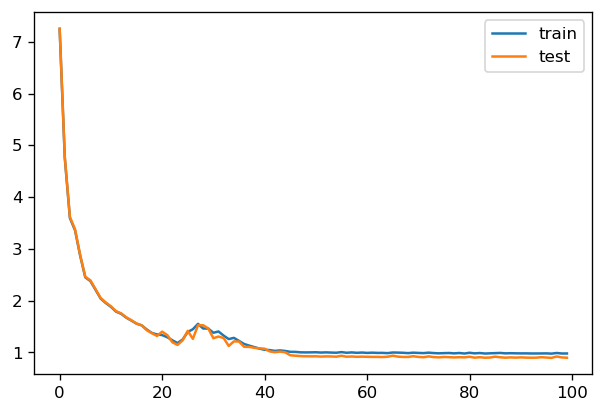

Test loss: 0.898126
Epoch 0, train loss: 7.606226
Epoch 1, train loss: 4.983535
Epoch 2, train loss: 3.605867
Epoch 3, train loss: 3.223027
Epoch 4, train loss: 2.973621
Epoch 5, train loss: 2.553643
Epoch 6, train loss: 2.262087
Epoch 7, train loss: 2.153311
Epoch 8, train loss: 2.006371
Epoch 9, train loss: 1.935292
Epoch 10, train loss: 1.851044
Epoch 11, train loss: 1.716586
Epoch 12, train loss: 1.750808
Epoch 13, train loss: 1.605146
Epoch 14, train loss: 1.496164
Epoch 15, train loss: 1.463873
Epoch 16, train loss: 1.417620
Epoch 17, train loss: 1.331975
Epoch 18, train loss: 1.227157
Epoch 19, train loss: 1.185195
Epoch 20, train loss: 1.155589
Epoch 21, train loss: 1.177203
Epoch 22, train loss: 1.192201
Epoch 23, train loss: 1.139602
Epoch 24, train loss: 1.086364
Epoch 25, train loss: 1.062268
Epoch 26, train loss: 1.050913
Epoch 27, train loss: 1.065466
Epoch 28, train loss: 1.057045
Epoch 29, train loss: 1.031999
Epoch 30, train loss: 1.024028
Epoch 31, train loss: 1.02054

In [ ]:
k = 5
epochs = 100 #40#100#80#100
verbose_epoch = -1 #95#75
learning_rate = 0.01 #0.1#0.001

weight_decay = 20 #130#100.0#80#200
train_loss, test_loss = k_fold_cross_valid(k, epochs, verbose_epoch, x_train,
                                           y_train, learning_rate, weight_decay)
print("%d-fold validation: Avg train loss: %f, Avg test loss: %f" %
      (k, train_loss, test_loss))

In [ ]:
def learn(epochs, verbose_epoch, x_train, y_train, test, learning_rate,
          weight_decay):
    net = get_net()
    train(net, x_train, y_train, None, None, epochs, verbose_epoch,
          learning_rate, weight_decay)
    preds = net(x_test).asnumpy()
#     preds = np.expm1(preds)
    sub['time_to_eruption'] = preds
    sub.to_csv('submission.csv', index=False)

Epoch 1, train loss: 3.339417
Epoch 2, train loss: 2.957497
Epoch 3, train loss: 2.740341
Epoch 4, train loss: 2.541465
Epoch 5, train loss: 2.455910
Epoch 6, train loss: 2.364795
Epoch 7, train loss: 2.289470
Epoch 8, train loss: 2.218364
Epoch 9, train loss: 2.142495
Epoch 10, train loss: 2.093625
Epoch 11, train loss: 2.030776
Epoch 12, train loss: 1.956487
Epoch 13, train loss: 1.888700
Epoch 14, train loss: 1.822083
Epoch 15, train loss: 1.760291
Epoch 16, train loss: 1.699715
Epoch 17, train loss: 1.645050
Epoch 18, train loss: 1.580480
Epoch 19, train loss: 1.526572
Epoch 20, train loss: 1.474027
Epoch 21, train loss: 1.420441
Epoch 22, train loss: 1.373950
Epoch 23, train loss: 1.328976
Epoch 24, train loss: 1.288465
Epoch 25, train loss: 1.248670
Epoch 26, train loss: 1.213796
Epoch 27, train loss: 1.183223
Epoch 28, train loss: 1.155612
Epoch 29, train loss: 1.154766
Epoch 30, train loss: 1.114451
Epoch 31, train loss: 1.096054
Epoch 32, train loss: 1.106942
Epoch 33, train l

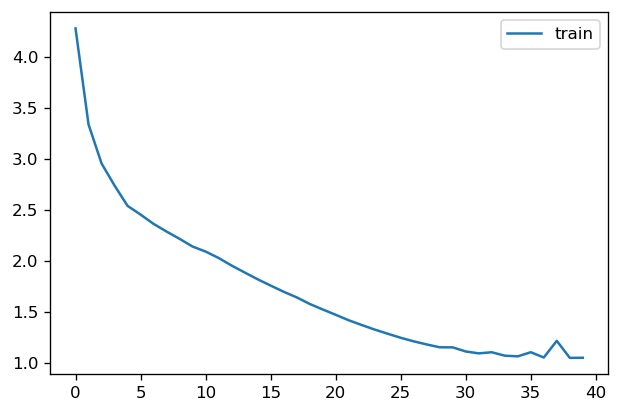

In [209]:
learn(epochs, verbose_epoch, x_train, y_train, test, learning_rate,
      weight_decay)